In [1]:
import numpy as np
print("Numpy version: "+np.__version__)
from sklearn import __version__ as skver
print("Scikit-learn version: "+skver)
from sklearn.datasets import make_blobs, make_moons
from sklearn.utils import check_random_state
from sklearn.base import BaseEstimator
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift 
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
%matplotlib inline
import matplotlib.pylab as plt
print("Matplotlib version: "+plt.__version__)

Numpy version: 1.13.1
Scikit-learn version: 0.19.0
Matplotlib version: 1.13.1


## 2D Data generation

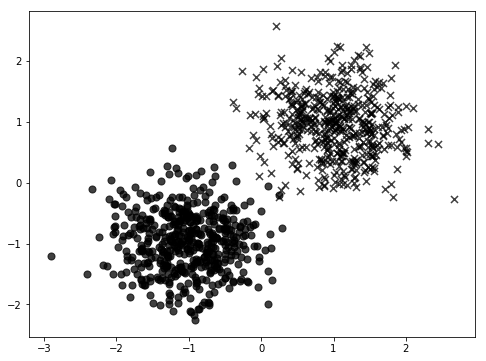

In [21]:
N = 1000  # number of samples
X, Y = make_blobs(n_samples=N, centers=[[1, 1], [-1, -1]], cluster_std=0.5)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[Y==0, 0], X[Y==0, 1], c='k', marker='x', 
           s=50, alpha=0.75, label='class 1')
ax.scatter(X[Y==1, 0], X[Y==1, 1], c='k', marker='o', 
           s=50, alpha=0.75, label='class 2')

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

## Vanilla k-means from sklearn

- The user has to set the number of clusters. Try n_clusters $\in \{2, 3, 5 \}$
- The number of random initializations is set with n_init
- There is also a mini-batch implementation for large databases: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

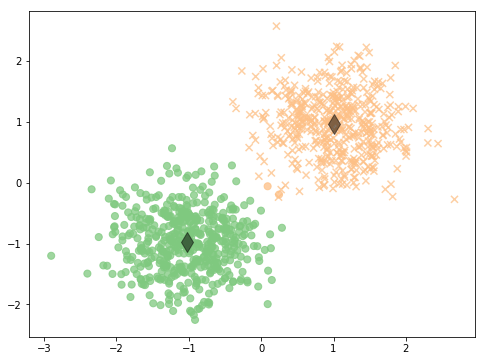

In [22]:
cluster_method = KMeans(n_clusters=2, init='random', n_init=10)
pred = cluster_method.fit_predict(X)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[Y==0, 0], X[Y==0, 1], c=pred[Y==0], marker='x', 
           s=50, alpha=0.75, label='class 1', cmap=plt.cm.Accent, vmin=0, vmax=cluster_method.n_clusters+1)
ax.scatter(X[Y==1, 0], X[Y==1, 1], c=pred[Y==1], marker='o', 
           s=50, alpha=0.75, label='class 2', cmap=plt.cm.Accent, vmin=0, vmax=cluster_method.n_clusters+1)

for point in cluster_method.cluster_centers_:
    ax.scatter(point[0], point[1], c='k', marker='d', s=200, alpha=.5)


## Custom k-means and k-medians

- Euclidean distance is replaced by Manhattan, and mean is replaced by the median
- Implementation with minor modifications from https://gist.github.com/mblondel/1451300
- The user has to set the number of clusters. Try $k \in \{2, 3, 5\}$

In [23]:
class KMeans_(BaseEstimator):

    def __init__(self, k, max_iter=100, random_state=0, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _e_step(self, X):
        self.labels_ = euclidean_distances(X, self.cluster_centers_,
                                     squared=True).argmin(axis=1)

    def _average(self, X):
        return X.mean(axis=0)

    def _m_step(self, X):
        X_center = None
        for center_id in range(self.k):
            center_mask = self.labels_ == center_id
            if not np.any(center_mask):
                # The centroid of empty clusters is set to the center of
                # everything
                if X_center is None:
                    X_center = self._average(X)
                self.cluster_centers_[center_id] = X_center
            else:
                self.cluster_centers_[center_id] = \
                    self._average(X[center_mask])

    def fit(self, X, y=None):
        n_samples = X.shape[0]
        vdata = np.mean(np.var(X, 0))

        random_state = check_random_state(self.random_state)
        self.labels_ = random_state.permutation(n_samples)[:self.k]
        self.cluster_centers_ = X[self.labels_]

        for i in range(self.max_iter):
            centers_old = self.cluster_centers_.copy()

            self._e_step(X)
            self._m_step(X)

            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata:
                break

        return self
    
class KMedians(KMeans_):

    def _e_step(self, X):
        self.labels_ = manhattan_distances(X, self.cluster_centers_).argmin(axis=1)

    def _average(self, X):
        return np.median(X, axis=0)

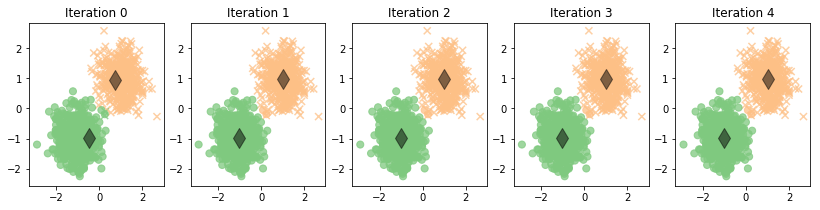

In [24]:
cluster_method = KMeans_(k=2, max_iter=0).fit(X)
fig = plt.figure(figsize=(14, 3))
for i in range(5):
    cluster_method._e_step(X)
    pred = cluster_method.labels_
    
    ax = fig.add_subplot(1, 5, i+1)
    ax.scatter(X[Y==0, 0], X[Y==0, 1], c=pred[Y==0], marker='x', 
               s=50, alpha=0.75, label='class 1', cmap=plt.cm.Accent, vmin=0, vmax=cluster_method.k+1)
    ax.scatter(X[Y==1, 0], X[Y==1, 1], c=pred[Y==1], marker='o', 
               s=50, alpha=0.75, label='class 2', cmap=plt.cm.Accent, vmin=0, vmax=cluster_method.k+1)
    for point in cluster_method.cluster_centers_:
        ax.scatter(point[0], point[1], c='k', marker='d', s=200, alpha=.5)
    plt.title('Iteration %d' %(i))
    cluster_method._m_step(X)

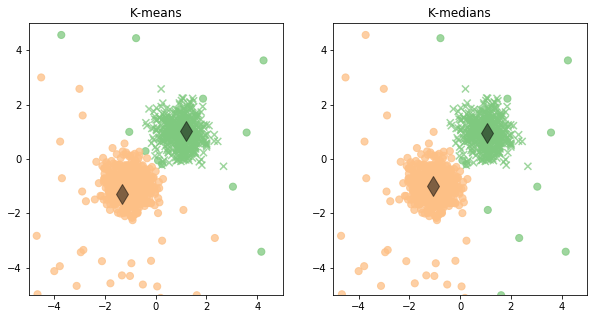

In [25]:
fig = plt.figure(figsize=(10, 5))
noisy_points = [-1, -1] + 6*np.random.randn(100, 2)
X_outliers = np.concatenate((X, noisy_points), axis=0)
Y_outliers = np.concatenate((Y, np.ones(shape=(100,))), axis=0)

cluster_method = KMeans_(k=2).fit(X_outliers)
pred = cluster_method.labels_
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X_outliers[Y_outliers==0, 0], X_outliers[Y_outliers==0, 1], c=pred[Y_outliers==0], marker='x', 
           s=50, alpha=0.75, label='class 1', cmap=plt.cm.Accent, vmin=0, vmax=cluster_method.k+1)
ax.scatter(X_outliers[Y_outliers==1, 0], X_outliers[Y_outliers==1, 1], c=pred[Y_outliers==1], marker='o', 
           s=50, alpha=0.75, label='class 2', cmap=plt.cm.Accent, vmin=0, vmax=cluster_method.k+1)
for point in cluster_method.cluster_centers_:
    ax.scatter(point[0], point[1], c='k', marker='d', s=200, alpha=.5)
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.title('K-means')

cluster_method = KMedians(k=2).fit(X_outliers)
pred = cluster_method.labels_
ax = fig.add_subplot(1, 2, 2)
ax.scatter(X_outliers[Y_outliers==0, 0], X_outliers[Y_outliers==0, 1], c=pred[Y_outliers==0], marker='x', 
           s=50, alpha=0.75, label='class 1', cmap=plt.cm.Accent, vmin=0, vmax=cluster_method.k+1)
ax.scatter(X_outliers[Y_outliers==1, 0], X_outliers[Y_outliers==1, 1], c=pred[Y_outliers==1], marker='o', 
           s=50, alpha=0.75, label='class 2', cmap=plt.cm.Accent, vmin=0, vmax=cluster_method.k+1)
plt.xlim([-5, 5])
plt.ylim([-5, 5])
for point in cluster_method.cluster_centers_:
    ax.scatter(point[0], point[1], c='k', marker='d', s=200, alpha=.5)
plt.title('K-medians')

## Fuzzy c-means
- Gives cluster probabilities instead of cluster labels 
- Implementation with minor modifications from https://gist.github.com/mblondel/1451300
- Parameter $q > 1$ controls the "fuzzyness" and $k$ the number of clusters
- Bezdek, James C. (1981). Pattern Recognition with Fuzzy Objective Function Algorithms. ISBN 0-306-40671-3.

In [26]:
class FuzzyCMeans(KMeans_):

    def _e_step(self, X):
        D = 1.0 / euclidean_distances(X, self.cluster_centers_, squared=True)
        D **= 1.0 / (self.q - 1)
        D /= np.sum(D, axis=1)[:, np.newaxis]
        # shape: n_samples x k
        self.fuzzy_labels_ = D
        self.labels_ = self.fuzzy_labels_.argmax(axis=1)
        
    def _m_step(self, X):
        weights = self.fuzzy_labels_ ** self.q
        # shape: n_clusters x n_features
        self.cluster_centers_ = np.dot(X.T, weights).T
        self.cluster_centers_ /= weights.sum(axis=0)[:, np.newaxis]

    def predict_proba(self, X):
        D = 1.0 / euclidean_distances(X, self.cluster_centers_, squared=True)
        D **= 1.0 / (self.q - 1)
        D /= np.sum(D, axis=1)[:, np.newaxis]
        return D
    
    def fit(self, X, y=None, q=2):
        n_samples, n_features = X.shape
        vdata = np.mean(np.var(X, 0))
        self.q = q
        random_state = check_random_state(self.random_state)
        self.fuzzy_labels_ = random_state.rand(n_samples, self.k)
        self.fuzzy_labels_ /= self.fuzzy_labels_.sum(axis=1)[:, np.newaxis]
        self._m_step(X)

        for i in range(self.max_iter):
            centers_old = self.cluster_centers_.copy()

            self._e_step(X)
            self._m_step(X)

            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata:
                break

        return self

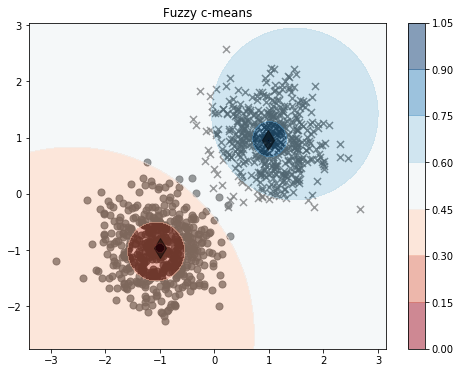

In [30]:
cluster_method = FuzzyCMeans(k=2)
cluster_method.fit(X, q=5)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[Y==0, 0], X[Y==0, 1], c='k', marker='x', 
           s=50, alpha=0.75, label='class 1')
ax.scatter(X[Y==1, 0], X[Y==1, 1], c='k', marker='o', 
           s=50, alpha=0.75, label='class 2')
Z = cluster_method.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
cr = ax.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5, vmin=0, vmax=1)
plt.colorbar(cr)
for point in cluster_method.cluster_centers_:
    ax.scatter(point[0], point[1], c='k', marker='d', s=200, alpha=.5)
plt.title('Fuzzy c-means')

## DBSCAN (Density-based Spatial Clustering of Applications with Noise)

- Uses the notion of sample density to find clusters
- Finds the number of clusters automatically
- It has two parameters: 
    - min_samples is the minimum number of neighbors a sample needs to become a core point
    - eps is the radius in which sample density is measured


Number of clusters: 3


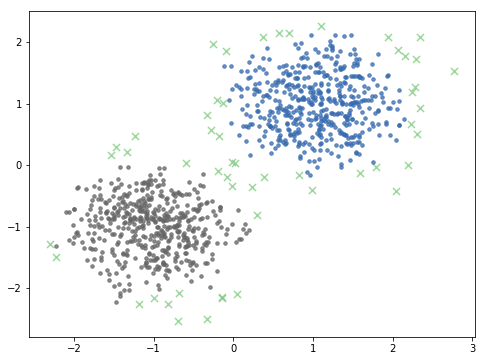

In [9]:
cluster_method = DBSCAN(min_samples=10, eps=0.25)
pred = cluster_method.fit_predict(X)
n_clusters = len(np.unique(pred)) 
print("Number of clusters: %d" %(n_clusters))
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
for label, c in zip(np.unique(pred), plt.cm.Accent(np.linspace(0, 1, n_clusters))):
    if label == -1: # noise cluster
        ax.scatter(X[pred==label, 0], X[pred==label,1], color=c, marker='x', 
                   s=50, alpha=0.75)
    else:
        ax.scatter(X[pred==label, 0], X[pred==label,1], color=c, marker='.', 
                   s=50, alpha=0.75)

#for idx in cluster_method.core_sample_indices_:
#    ax.scatter(X[idx, 0], X[idx, 1], c='k', marker='d', s=100, alpha=.25)

## Agglomerative Clustering

- Requires that the user specifies the number of clusters (n_clusters)
- Linkage criterion measures proximity between clusters
    - average linkage is the average distance between one element of a cluster and all the others
    - The user can define the distance metric

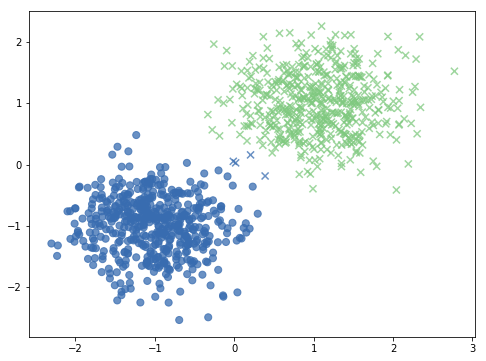

In [10]:
cluster_method = AgglomerativeClustering(n_clusters=2, 
                                         linkage="average", affinity="cityblock")
pred =cluster_method.fit_predict(X)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[Y==0, 0], X[Y==0, 1], c=pred[Y==0], marker='x', 
           s=50, alpha=0.75, label='class 1', cmap=plt.cm.Accent, vmin=0, vmax=cluster_method.n_clusters)
ax.scatter(X[Y==1, 0], X[Y==1, 1], c=pred[Y==1], marker='o', 
           s=50, alpha=0.75, label='class 2', cmap=plt.cm.Accent, vmin=0, vmax=cluster_method.n_clusters)

## Mean Shift
- Based on kernel density estimation (KDE)
- Does not need to specify the number of clusters
- It finds the modes of the data distribution by differentiating the KDE
- The user needs to provide the bandwidth for the Gaussian kernels in the KDE

Number of clusters: 2


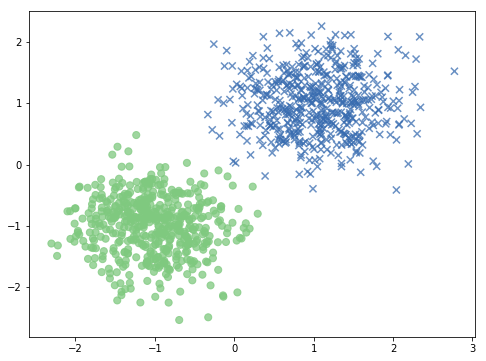

In [11]:
cluster_method = MeanShift(bandwidth=1.0, min_bin_freq=5)
pred =cluster_method.fit_predict(X)

n_clusters = len(np.unique(pred)) 
print("Number of clusters: %d" %(n_clusters))
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[Y==0, 0], X[Y==0, 1], c=pred[Y==0], marker='x', 
           s=50, alpha=0.75, label='class 1', cmap=plt.cm.Accent, vmin=0, vmax=n_clusters)
ax.scatter(X[Y==1, 0], X[Y==1, 1], c=pred[Y==1], marker='o', 
           s=50, alpha=0.75, label='class 2', cmap=plt.cm.Accent, vmin=0, vmax=n_clusters)

## Gaussian mixture models

- Clusters are modelled as full-covariance Gaussians
- Outputs are probabilistic
- The algorithms learns the mixing ratios and the Gaussian parameters
- Uses Expectation-Maximization
- There is a variational implementation in sklearn.mixture.BayesianGaussianMixture

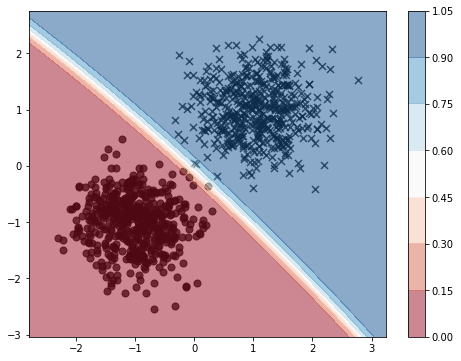

In [12]:
cluster_method = GaussianMixture(n_components=2).fit(X)
pred = cluster_method.predict_proba(X)[:, 1]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[Y==0, 0], X[Y==0, 1], c='k', marker='x', 
           s=50, alpha=0.75, label='class 1')
ax.scatter(X[Y==1, 0], X[Y==1, 1], c='k', marker='o', 
           s=50, alpha=0.75, label='class 2')
Z = cluster_method.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
cr = ax.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5)
plt.colorbar(cr)


## Choosing the number of clusters using K-means objective
- The objective function of K-means is the sum of squared errors
- The score function gives the negative of the objective function

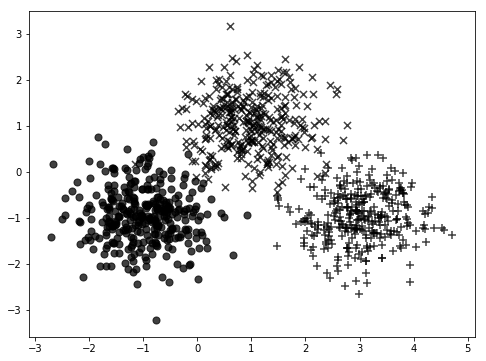

In [13]:
N = 1000  # number of samples
X, Y = make_blobs(n_samples=N, centers=[[1, 1], [-1, -1], [3, -1]], cluster_std=0.6)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[Y==0, 0], X[Y==0, 1], c='k', marker='x', 
           s=50, alpha=0.75, label='class 1')
ax.scatter(X[Y==1, 0], X[Y==1, 1], c='k', marker='o', 
           s=50, alpha=0.75, label='class 2')
ax.scatter(X[Y==2, 0], X[Y==2, 1], c='k', marker='+', 
           s=50, alpha=0.75, label='class 3')
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

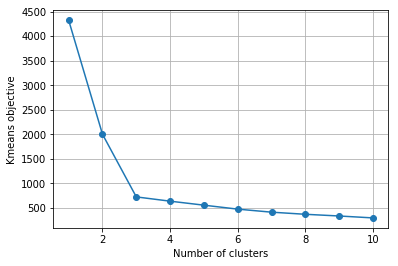

In [14]:
obj = []
for k in range(10):
    cluster_method = KMeans(n_clusters=k+1, init='random', n_init=10).fit(X)
    obj.append(-cluster_method.score(X))
plt.plot(np.linspace(1, 10, num=len(obj)), obj, 'o-')
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Kmeans objective')